In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

results_dir = "[3] Test Input"

input_dir = "[4] TT Input"

""" output_dir = "Top Tester Results"

os.makedirs(output_dir, exist_ok=True) """

' output_dir = "Top Tester Results"\n\nos.makedirs(output_dir, exist_ok=True) '

In [2]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Raw dataframes: ['RESULTS', 'RESULTS_ASR_control', 'RESULTS_MERGED', 'RESULTS_MERGED_ASR_control', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_DATE_ASR_control', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MT10_ASR_control', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_ASR_control', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE_ASR_control', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_T10_ASR_control', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_ASR_control', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE_ASR_control', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder', 'SegmentOrder_ASR_control']
Fit dataframes: []
Found 23 raw and 0 fit dataframes in [3] Test Input.

Found 1 experiments, 6 variables and 4 parameters:
 ASR_control
 reactionTime, peakValue, PTPA, PTTA, RMS, AUC
 animal, sex, date, experiment


In [3]:
# ...existing code...
before = len(dfs)
files = [file for file in os.listdir(input_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(input_dir, file)
    key = file.split('.')[0]
    dfs[key] = pd.read_excel(file_path)
    print(f"Loaded {file} into dataframe with key '{key}'.")

print("All dataframes:", list(dfs.keys()))

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

Loaded C10.xlsx into dataframe with key 'C10'.
Loaded C20.xlsx into dataframe with key 'C20'.
Loaded C30.xlsx into dataframe with key 'C30'.
Loaded C40.xlsx into dataframe with key 'C40'.
Loaded C50.xlsx into dataframe with key 'C50'.
Loaded CM10.xlsx into dataframe with key 'CM10'.
Loaded CM20.xlsx into dataframe with key 'CM20'.
Loaded CM30.xlsx into dataframe with key 'CM30'.
Loaded CM40.xlsx into dataframe with key 'CM40'.
Loaded CM50.xlsx into dataframe with key 'CM50'.
Loaded RESULTS_MT10.xlsx into dataframe with key 'RESULTS_MT10'.
Loaded RESULTS_MT20.xlsx into dataframe with key 'RESULTS_MT20'.
Loaded RESULTS_MT30.xlsx into dataframe with key 'RESULTS_MT30'.
Loaded RESULTS_MT40.xlsx into dataframe with key 'RESULTS_MT40'.
Loaded RESULTS_MT50.xlsx into dataframe with key 'RESULTS_MT50'.
Loaded RESULTS_T10.xlsx into dataframe with key 'RESULTS_T10'.
Loaded RESULTS_T20.xlsx into dataframe with key 'RESULTS_T20'.
Loaded RESULTS_T30.xlsx into dataframe with key 'RESULTS_T30'.
Loaded

In [4]:
# ...existing code...

from scipy.stats import ttest_ind

def compare_dataframes(df1, df2, parameters, variables):
    results = []
    # Get all unique parameter combinations in df1
    param_combos = df1[parameters].drop_duplicates()
    for _, combo in param_combos.iterrows():
        # Filter both dataframes for this parameter combo
        mask1 = (df1[parameters] == combo.values).all(axis=1)
        mask2 = (df2[parameters] == combo.values).all(axis=1)
        if mask1.sum() == 0 or mask2.sum() == 0:
            continue  # Skip if combo not present in both
        for var in variables:
            data1 = df1.loc[mask1, var].dropna()
            data2 = df2.loc[mask2, var].dropna()
            if len(data1) < 2 or len(data2) < 2:
                continue  # Need at least 2 samples for t-test
            stat, p = ttest_ind(data1, data2, equal_var=False, nan_policy='omit')
            results.append({
                **dict(zip(parameters, combo.values)),
                'variable': var,
                'statistic': stat,
                'p_value': p,
                'n_df1': len(data1),
                'n_df2': len(data2)
            })
    return pd.DataFrame(results)
# ...existing code...

In [5]:
# ...existing code...

import ast

def flatten_column(col):
    # Flattens a column of lists, stringified lists, or scalars into a single list of numbers
    out = []
    for item in col.dropna():
        if isinstance(item, list):
            out.extend(item)
        elif isinstance(item, str):
            try:
                parsed = ast.literal_eval(item)
                if isinstance(parsed, list):
                    out.extend(parsed)
                elif isinstance(parsed, (int, float, np.integer, np.floating)):
                    out.append(parsed)
            except Exception:
                continue  # Ignore strings that can't be parsed
        elif isinstance(item, (int, float, np.integer, np.floating)):
            out.append(item)
        # Ignore non-numeric, non-list
    return pd.Series(out)

# ...existing code...

def compare_general_trends(df1, df2, variables):
    summary = []
    for var in variables:
        flat1 = flatten_column(df1[var])
        flat2 = flatten_column(df2[var])
        if len(flat1) > 0 and len(flat2) > 0:
            mean_diff = flat1.mean() - flat2.mean()
            stats = {
                'mean_difference': mean_diff,
                'df1_median': flat1.median(),
                'df1_std': flat1.std(),
                'df1_n': flat1.count(),
                'df2_median': flat2.median(),
                'df2_std': flat2.std(),
                'df2_n': flat2.count(),
            }
            summary.append({
                'variable': var,
                **stats
            })
        else:
            summary.append({
                'variable': var,
                'mean_difference': 'no data',
                'df1_median': 'no data',
                'df1_std': 'no data',
                'df1_n': len(flat1),
                'df2_median': 'no data',
                'df2_std': 'no data',
                'df2_n': len(flat2),
            })
    return pd.DataFrame(summary)


# ...existing code...

from scipy.stats import ttest_ind

def test_general_trend_significance(df1, df2, variables):
    results = []
    for var in variables:
        flat1 = flatten_column(df1[var])
        flat2 = flatten_column(df2[var])
        if len(flat1) > 1 and len(flat2) > 1:
            stat, p = ttest_ind(flat1, flat2, equal_var=False, nan_policy='omit')
            results.append({
                'variable': var,
                'n_df1': len(flat1),
                'n_df2': len(flat2),
                'statistic': stat,
                'p_value': p
            })
        else:
            results.append({
                'variable': var,
                'n_df1': len(flat1),
                'n_df2': len(flat2),
                'statistic': 'no data',
                'p_value': 'no data'
            })
    return pd.DataFrame(results)

# ...existing code...

In [6]:
# ...existing code...

def compare_general_trends_by_sex(df1, df2, variables):
    summary = []
    sexes = sorted(set(df1['sex'].dropna().unique()).union(df2['sex'].dropna().unique()))
    for sex in sexes:
        df1_sex = df1[df1['sex'] == sex]
        df2_sex = df2[df2['sex'] == sex]
        for var in variables:
            flat1 = flatten_column(df1_sex[var]) if var in df1_sex else pd.Series([])
            flat2 = flatten_column(df2_sex[var]) if var in df2_sex else pd.Series([])
            if len(flat1) > 0 and len(flat2) > 0:
                mean_diff = flat1.mean() - flat2.mean()
                stats = {
                    'sex': sex,
                    'variable': var,
                    'mean_difference': mean_diff,
                    'df1_median': flat1.median(),
                    'df1_std': flat1.std(),
                    'df1_n': flat1.count(),
                    'df2_median': flat2.median(),
                    'df2_std': flat2.std(),
                    'df2_n': flat2.count(),
                }
                summary.append(stats)
            else:
                summary.append({
                    'sex': sex,
                    'variable': var,
                    'mean_difference': 'no data',
                    'df1_median': 'no data',
                    'df1_std': 'no data',
                    'df1_n': len(flat1),
                    'df2_median': 'no data',
                    'df2_std': 'no data',
                    'df2_n': len(flat2),
                })
    return pd.DataFrame(summary)
# ...existing code...

from scipy.stats import ttest_ind

def test_general_trend_significance_by_sex(df1, df2, variables):
    results = []
    sexes = sorted(set(df1['sex'].dropna().unique()).union(df2['sex'].dropna().unique()))
    for sex in sexes:
        df1_sex = df1[df1['sex'] == sex]
        df2_sex = df2[df2['sex'] == sex]
        for var in variables:
            flat1 = flatten_column(df1_sex[var]) if var in df1_sex else pd.Series([])
            flat2 = flatten_column(df2_sex[var]) if var in df2_sex else pd.Series([])
            if len(flat1) > 1 and len(flat2) > 1:
                stat, p = ttest_ind(flat1, flat2, equal_var=False, nan_policy='omit')
                results.append({
                    'sex': sex,
                    'variable': var,
                    'n_df1': len(flat1),
                    'n_df2': len(flat2),
                    'statistic': stat,
                    'p_value': p
                })
            else:
                results.append({
                    'sex': sex,
                    'variable': var,
                    'n_df1': len(flat1),
                    'n_df2': len(flat2),
                    'statistic': 'no data',
                    'p_value': 'no data'
                })
    return pd.DataFrame(results)

# ...existing code...


In [7]:
df1 = dfs['RESULTS_T10']
df2 = dfs['RESULTS_MT10']

In [8]:
result_df = compare_dataframes(df1, df2, parameters, variables)
print(result_df)

Empty DataFrame
Columns: []
Index: []


In [9]:
trend_df = compare_general_trends(df1, df2, variables)
print(trend_df)

       variable  mean_difference   df1_median      df1_std  df1_n  \
0  reactionTime         0.996988    30.000000     6.881653      8   
1     peakValue        -7.766566    49.500000    23.412070      8   
2          PTPA        -8.237831    48.433559    22.390664      8   
3          PTTA        -6.166713    47.205369    20.808285      8   
4           RMS        -2.886114    15.885000     7.128646      8   
5           AUC      -343.973313  1832.845000  1080.677058      8   

    df2_median      df2_std  df2_n  
0    30.000000     6.919121     83  
1    54.000000    34.810291     83  
2    51.915760    33.072861     83  
3    49.848755    29.208942     83  
4    17.540000    11.542411     83  
5  2174.970000  1546.076874     83  


In [10]:
print("Top 10:")
trend_df = compare_general_trends(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(trend_df)
sig_df = test_general_trend_significance(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(sig_df)

Top 10:
       variable  mean_difference   df1_median      df1_std  df1_n  \
0  reactionTime         0.996988    30.000000     6.881653      8   
1     peakValue        -7.766566    49.500000    23.412070      8   
2          PTPA        -8.237831    48.433559    22.390664      8   
3          PTTA        -6.166713    47.205369    20.808285      8   
4           RMS        -2.886114    15.885000     7.128646      8   
5           AUC      -343.973313  1832.845000  1080.677058      8   

    df2_median      df2_std  df2_n  
0    30.000000     6.919121     83  
1    54.000000    34.810291     83  
2    51.915760    33.072861     83  
3    49.848755    29.208942     83  
4    17.540000    11.542411     83  
5  2174.970000  1546.076874     83  
       variable  n_df1  n_df2  statistic   p_value
0  reactionTime      8     83   0.391158  0.705389
1     peakValue      8     83  -0.851901  0.413709
2          PTPA      8     83  -0.945902  0.366036
3          PTTA      8     83  -0.768429  0.4

In [11]:
print("Top 10:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T10'], dfs['RESULTS_MT10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T20'], dfs['RESULTS_MT20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T30'], dfs['RESULTS_MT30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T40'], dfs['RESULTS_MT40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends_by_sex(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['RESULTS_T50'], dfs['RESULTS_MT50'], variables)
print(sig_df)

Top 10:
       sex      variable  mean_difference   df1_median      df1_std  df1_n  \
0   female  reactionTime        -2.590476    30.000000     6.985700      5   
1   female     peakValue         7.885714    43.000000    15.565989      5   
2   female          PTPA         5.904546    41.120196    14.425706      5   
3   female          PTTA         6.354585    41.120196    15.663921      5   
4   female           RMS         2.391857    13.430000     4.796335      5   
5   female           AUC       404.526381  1529.840000   941.898309      5   
6     male  reactionTime         5.089431    32.000000     8.082904      3   
7     male     peakValue       -20.252033    66.000000    35.076108      3   
8     male          PTPA       -18.928174    65.917283    33.249110      3   
9     male          PTTA       -15.792537    60.824182    29.311300      3   
10    male           RMS        -7.256504    23.110000    10.700282      3   
11    male           AUC      -971.373740  2661.690000  

In [12]:
print("Top 10:")
trend_df = compare_general_trends_by_sex(dfs['C10'], dfs['CM10'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C10'], dfs['CM10'], variables)
print(sig_df)

print("Top 20:")
trend_df = compare_general_trends_by_sex(dfs['C20'], dfs['CM20'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C20'], dfs['CM20'], variables)
print(sig_df)

print("Top 30:")
trend_df = compare_general_trends_by_sex(dfs['C30'], dfs['CM30'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C30'], dfs['CM30'], variables)
print(sig_df)

print("Top 40:")
trend_df = compare_general_trends_by_sex(dfs['C40'], dfs['CM40'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C40'], dfs['CM40'], variables)
print(sig_df)

print("Top 50:")
trend_df = compare_general_trends_by_sex(dfs['C50'], dfs['CM50'], variables)
print(trend_df)
sig_df = test_general_trend_significance_by_sex(dfs['C50'], dfs['CM50'], variables)
print(sig_df)

Top 10:
       sex      variable  mean_difference   df1_median      df1_std  df1_n  \
0   female  reactionTime         3.220930    32.000000     1.000000      4   
1   female     peakValue        -6.965116    35.000000     9.949874      4   
2   female          PTPA        -6.472071    34.314973     9.475669      4   
3   female          PTTA        -6.411366    30.269971    10.221580      4   
4   female           RMS        -2.120988    12.090000     3.600994      4   
5   female           AUC      -544.524128  1134.780000   265.686346      4   
6     male  reactionTime        -2.185366    18.000000     5.366563      5   
7     male     peakValue         0.834146    89.000000    36.547230      5   
8     male          PTPA        -1.905780    83.924681    30.284415      5   
9     male          PTTA         0.926132    79.496418    26.222984      5   
10    male           RMS         0.541805    26.530000    12.469045      5   
11    male           AUC        56.311854  3566.880000  

Reaction Time Slopes:
  Male Exp:   0.0511
  Male Ctrl:  0.0357
  Female Exp: -5.2162
  Female Ctrl:-0.0673
Peak Value Slopes:
  Male Exp:   -0.0259
  Male Ctrl:  0.0522
  Female Exp: -0.1913
  Female Ctrl:-0.0287
Peak Value (Male, line): U=-1.96, p=0.0933
Peak Value (Female, line): U=2.09, p=0.1018
Reaction Time (Male, line): U=0.08, p=0.9372
Reaction Time (Female, line): U=1.18, p=0.3021


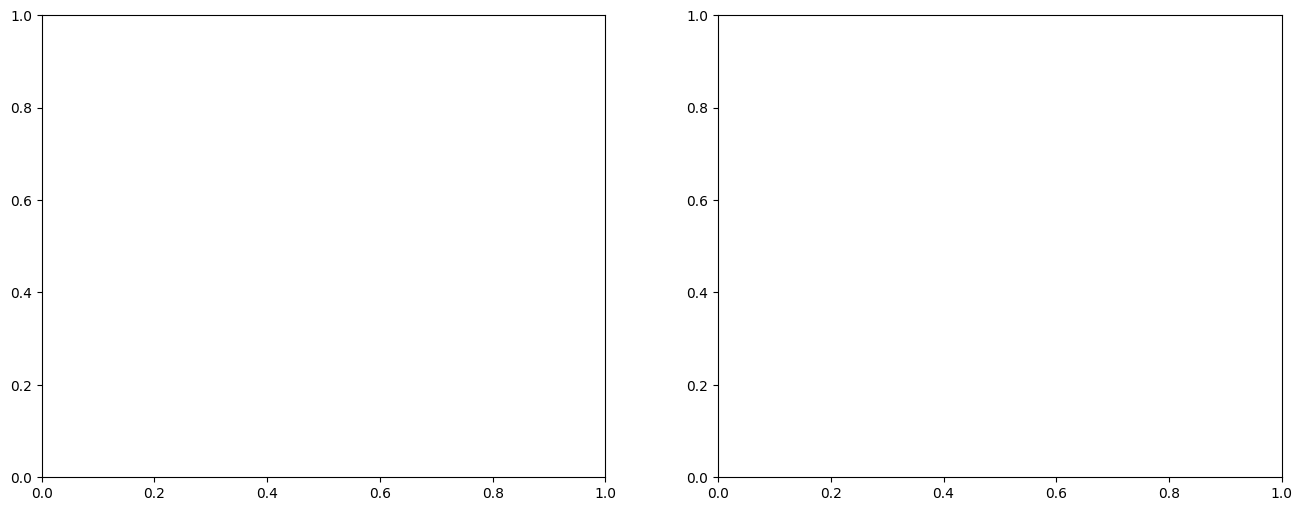

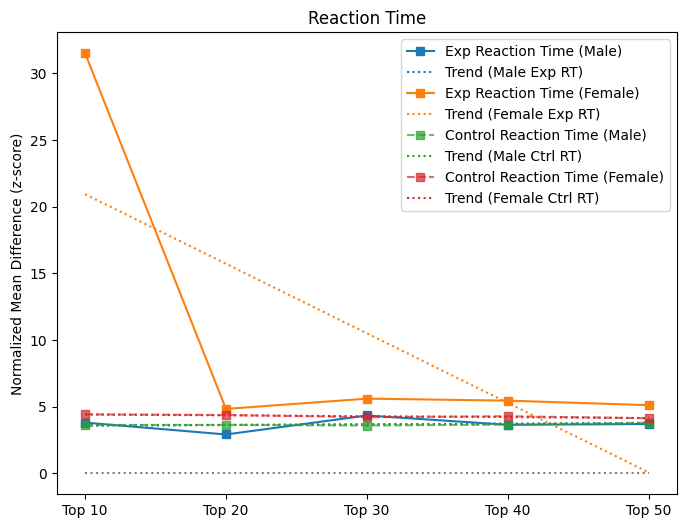

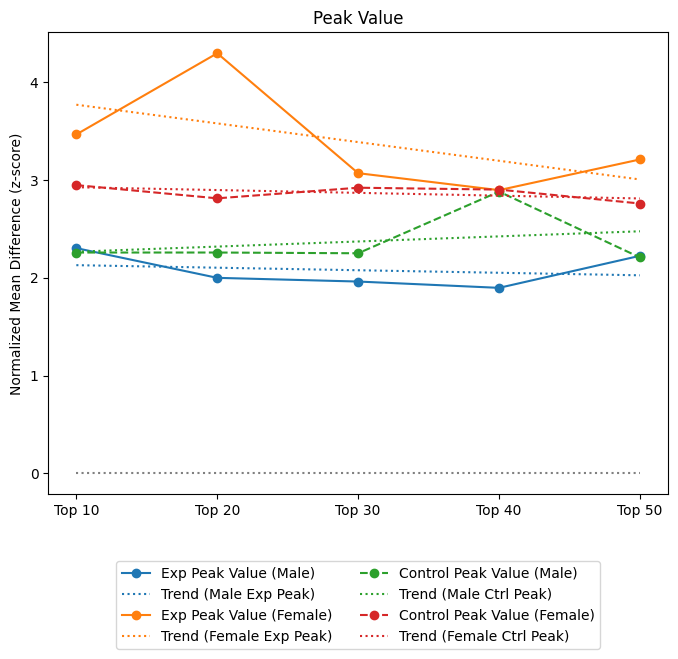

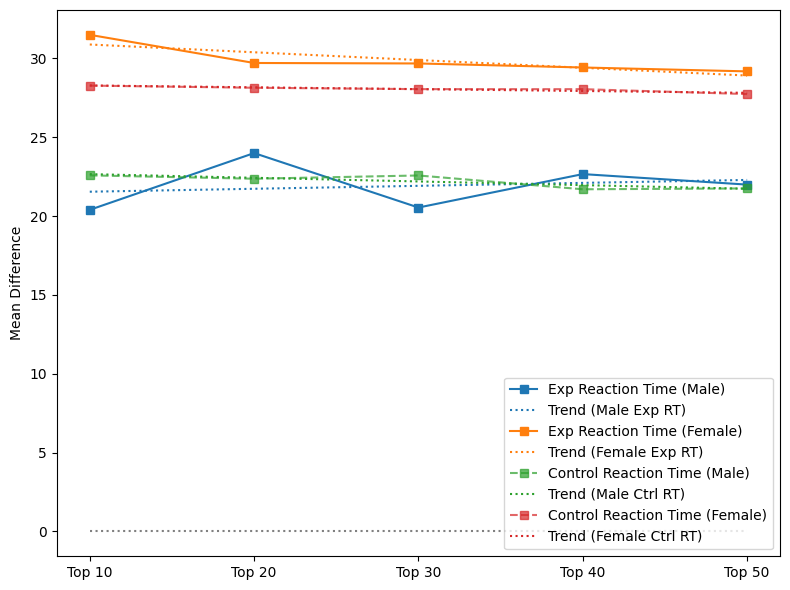

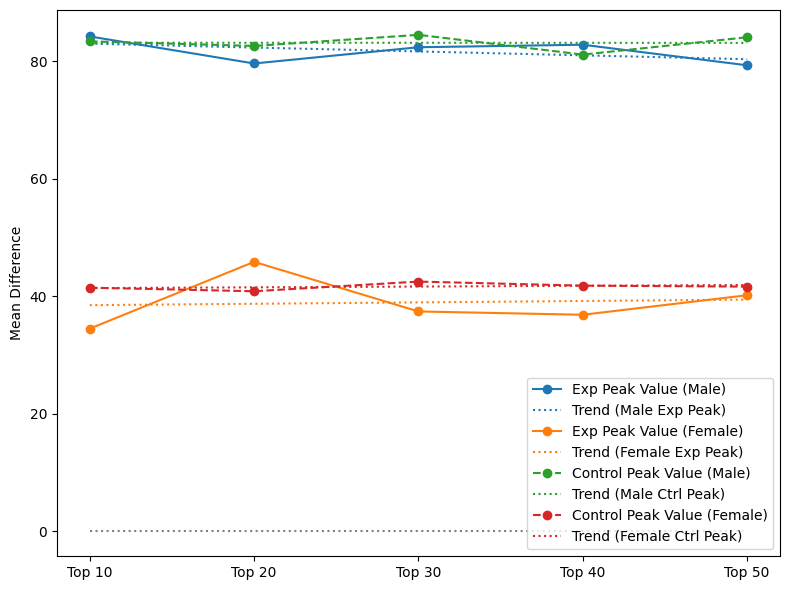

Reaction Time Slopes:
  Male Exp:   0.1867
  Male Ctrl:  -0.2324
  Female Exp: -0.4922
  Female Ctrl:-0.1163
Peak Value Slopes:
  Male Exp:   -0.6625
  Male Ctrl:  -0.0081
  Female Exp: 0.2364
  Female Ctrl:0.1314
Peak Value (Male, line): t=-1.31, p=0.2334
Peak Value (Female, line): t=-1.37, p=0.2400
Reaction Time (Male, line): t=-0.39, p=0.7104
Reaction Time (Female, line): t=4.39, p=0.0096


In [13]:
# ...existing code...

def extract_raw_means_stds_by_sex(df, variable):
    # Returns ([male_mean, female_mean], [male_std, female_std]) for a given variable
    sexes = ['male', 'female']
    means = []
    stds = []
    for sex in sexes:
        df_sex = df[df['sex'] == sex]
        flat = flatten_column(df_sex[variable]) if variable in df_sex else pd.Series([])
        means.append(flat.mean() if len(flat) > 0 else np.nan)
        stds.append(flat.std() if len(flat) > 0 else np.nan)
    return means, stds

# Replace extraction in build_sex_lists:
def build_sex_lists(top_keys, control_keys, variables):
    exp_peak_means, exp_peak_stds = [], []
    exp_rt_means, exp_rt_stds = [], []
    ctrl_peak_means, ctrl_peak_stds = [], []
    ctrl_rt_means, ctrl_rt_stds = [], []
    for exp_key, ctrl_key in zip(top_keys, control_keys):
        peak_means, peak_stds = extract_raw_means_stds_by_sex(dfs[exp_key], 'peakValue')
        exp_peak_means.append(peak_means)
        exp_peak_stds.append(peak_stds)
        rt_means, rt_stds = extract_raw_means_stds_by_sex(dfs[exp_key], 'reactionTime')
        exp_rt_means.append(rt_means)
        exp_rt_stds.append(rt_stds)
        peak_means_ctrl, peak_stds_ctrl = extract_raw_means_stds_by_sex(dfs[ctrl_key], 'peakValue')
        ctrl_peak_means.append(peak_means_ctrl)
        ctrl_peak_stds.append(peak_stds_ctrl)
        rt_means_ctrl, rt_stds_ctrl = extract_raw_means_stds_by_sex(dfs[ctrl_key], 'reactionTime')
        ctrl_rt_means.append(rt_means_ctrl)
        ctrl_rt_stds.append(rt_stds_ctrl)
    return exp_peak_means, exp_peak_stds, exp_rt_means, exp_rt_stds, ctrl_peak_means, ctrl_peak_stds, ctrl_rt_means, ctrl_rt_stds

# Define your keys and variables
top_keys = ['C10', 'C20', 'C30', 'C40', 'C50']
control_keys = ['CM10', 'CM20', 'CM30', 'CM40', 'CM50']
variables = ['peakValue', 'reactionTime']

# Build lists dynamically
(peakvalue_means_by_sex, peakvalue_stds_by_sex,
 reactiontime_means_by_sex, reactiontime_stds_by_sex,
 control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex,
 control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex) = build_sex_lists(top_keys, control_keys, variables)

xticks = ['Top 10', 'Top 20', 'Top 30', 'Top 40', 'Top 50']
x = np.arange(len(xticks))

# Normalize by standard deviation (z-score)
male_peak_norm = [v[0]/s[0] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
female_peak_norm = [v[1]/s[1] for v, s in zip(peakvalue_means_by_sex, peakvalue_stds_by_sex)]
male_rt_norm = [v[0]/s[0] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]
female_rt_norm = [v[1]/s[1] for v, s in zip(reactiontime_means_by_sex, reactiontime_stds_by_sex)]

male_peak_control_norm = [v[0]/s[0] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
female_peak_control_norm = [v[1]/s[1] for v, s in zip(control_peakvalue_means_by_sex, control_peakvalue_stds_by_sex)]
male_rt_control_norm = [v[0]/s[0] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]
female_rt_control_norm = [v[1]/s[1] for v, s in zip(control_reactiontime_means_by_sex, control_reactiontime_stds_by_sex)]

# ...existing code...
# ...existing code...

def plot_trendline(ax, x, y, color, linestyle, label):
    coeffs = np.polyfit(x, y, 1)
    trend = np.polyval(coeffs, x)
    ax.plot(x, trend, color=color, linestyle=linestyle, alpha=1, label=label)
    return coeffs[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# --- Reaction Time Plot ---
fig_rt, ax_rt = plt.subplots(figsize=(8, 6))
ax_rt.plot(x, male_rt_norm, marker='s', linestyle='-', label='Exp Reaction Time (Male)', color='tab:blue')
plot_trendline(ax_rt, x, male_rt_norm, color='tab:blue', linestyle=':', label='Trend (Male Exp RT)')
ax_rt.plot(x, female_rt_norm, marker='s', linestyle='-', label='Exp Reaction Time (Female)', color='tab:orange')
plot_trendline(ax_rt, x, female_rt_norm, color='tab:orange', linestyle=':', label='Trend (Female Exp RT)')
ax_rt.plot(x, male_rt_control_norm, marker='s', linestyle='--', label='Control Reaction Time (Male)', color='tab:green', alpha=0.7)
plot_trendline(ax_rt, x, male_rt_control_norm, color='tab:green', linestyle=':', label='Trend (Male Ctrl RT)')
ax_rt.plot(x, female_rt_control_norm, marker='s', linestyle='--', label='Control Reaction Time (Female)', color='tab:red', alpha=0.7)
plot_trendline(ax_rt, x, female_rt_control_norm, color='tab:red', linestyle=':', label='Trend (Female Ctrl RT)')
ax_rt.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_rt.set_xticks(x)
ax_rt.set_xticklabels(xticks)
ax_rt.set_ylabel('Normalized Mean Difference (z-score)')
ax_rt.set_title('Reaction Time')
ax_rt.legend()#loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)


# --- Peak Value Plot ---
fig_peak, ax_peak = plt.subplots(figsize=(8, 6))
ax_peak.plot(x, male_peak_norm, marker='o', linestyle='-', label='Exp Peak Value (Male)', color='tab:blue')
plot_trendline(ax_peak, x, male_peak_norm, color='tab:blue', linestyle=':', label='Trend (Male Exp Peak)')
ax_peak.plot(x, female_peak_norm, marker='o', linestyle='-', label='Exp Peak Value (Female)', color='tab:orange')
plot_trendline(ax_peak, x, female_peak_norm, color='tab:orange', linestyle=':', label='Trend (Female Exp Peak)')
ax_peak.plot(x, male_peak_control_norm, marker='o', linestyle='--', label='Control Peak Value (Male)', color='tab:green')
plot_trendline(ax_peak, x, male_peak_control_norm, color='tab:green', linestyle=':', label='Trend (Male Ctrl Peak)')
ax_peak.plot(x, female_peak_control_norm, marker='o', linestyle='--', label='Control Peak Value (Female)', color='tab:red')
plot_trendline(ax_peak, x, female_peak_control_norm, color='tab:red', linestyle=':', label='Trend (Female Ctrl Peak)')
ax_peak.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_peak.set_xticks(x)
ax_peak.set_xticklabels(xticks)
ax_peak.set_ylabel('Normalized Mean Difference (z-score)')
ax_peak.set_title('Peak Value')
ax_peak.legend(loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=2)

# ...existing code..
# 

from scipy.stats import mannwhitneyu

def get_slope(x, y):
    coeffs = np.polyfit(x, y, 1)
    return coeffs[0]

# Calculate slopes for each group
male_exp_rt_slope = get_slope(x, male_rt_norm)
female_exp_rt_slope = get_slope(x, female_rt_norm)
male_ctrl_rt_slope = get_slope(x, male_rt_control_norm)
female_ctrl_rt_slope = get_slope(x, female_rt_control_norm)

male_exp_peak_slope = get_slope(x, male_peak_norm)
female_exp_peak_slope = get_slope(x, female_peak_norm)
male_ctrl_peak_slope = get_slope(x, male_peak_control_norm)
female_ctrl_peak_slope = get_slope(x, female_peak_control_norm)

print("Reaction Time Slopes:")
print(f"  Male Exp:   {male_exp_rt_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_rt_slope:.4f}")
print(f"  Female Exp: {female_exp_rt_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_rt_slope:.4f}")

print("Peak Value Slopes:")
print(f"  Male Exp:   {male_exp_peak_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_peak_slope:.4f}")
print(f"  Female Exp: {female_exp_peak_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_peak_slope:.4f}")

def print_line_diff_test_nonparametric(exp, ctrl, label):
    stat, p = ttest_ind(exp, ctrl, equal_var=False, nan_policy='omit')
    print(f"{label}: U={stat:.2f}, p={p:.4f}")

print_line_diff_test_nonparametric(male_peak_norm, male_peak_control_norm, "Peak Value (Male, line)")
print_line_diff_test_nonparametric(female_peak_norm, female_peak_control_norm, "Peak Value (Female, line)")
print_line_diff_test_nonparametric(male_rt_norm, male_rt_control_norm, "Reaction Time (Male, line)")
print_line_diff_test_nonparametric(female_rt_norm, female_rt_control_norm, "Reaction Time (Female, line)")





# ...existing code...

# Use raw mean differences instead of normalized values
male_peak_means = [v[0] for v in peakvalue_means_by_sex]
female_peak_means = [v[1] for v in peakvalue_means_by_sex]
male_rt_means = [v[0] for v in reactiontime_means_by_sex]
female_rt_means = [v[1] for v in reactiontime_means_by_sex]

male_peak_control_means = [v[0] for v in control_peakvalue_means_by_sex]
female_peak_control_means = [v[1] for v in control_peakvalue_means_by_sex]
male_rt_control_means = [v[0] for v in control_reactiontime_means_by_sex]
female_rt_control_means = [v[1] for v in control_reactiontime_means_by_sex]

# --- Reaction Time Plot ---
fig_rt, ax_rt = plt.subplots(figsize=(8, 6))
ax_rt.plot(x, male_rt_means, marker='s', linestyle='-', label='Exp Reaction Time (Male)', color='tab:blue')
plot_trendline(ax_rt, x, male_rt_means, color='tab:blue', linestyle=':', label='Trend (Male Exp RT)')
ax_rt.plot(x, female_rt_means, marker='s', linestyle='-', label='Exp Reaction Time (Female)', color='tab:orange')
plot_trendline(ax_rt, x, female_rt_means, color='tab:orange', linestyle=':', label='Trend (Female Exp RT)')
ax_rt.plot(x, male_rt_control_means, marker='s', linestyle='--', label='Control Reaction Time (Male)', color='tab:green', alpha=0.7)
plot_trendline(ax_rt, x, male_rt_control_means, color='tab:green', linestyle=':', label='Trend (Male Ctrl RT)')
ax_rt.plot(x, female_rt_control_means, marker='s', linestyle='--', label='Control Reaction Time (Female)', color='tab:red', alpha=0.7)
plot_trendline(ax_rt, x, female_rt_control_means, color='tab:red', linestyle=':', label='Trend (Female Ctrl RT)')
ax_rt.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_rt.set_xticks(x)
ax_rt.set_xticklabels(xticks)
ax_rt.set_ylabel('Mean Difference')
ax_rt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

# --- Peak Value Plot ---
fig_peak, ax_peak = plt.subplots(figsize=(8, 6))
ax_peak.plot(x, male_peak_means, marker='o', linestyle='-', label='Exp Peak Value (Male)', color='tab:blue')
plot_trendline(ax_peak, x, male_peak_means, color='tab:blue', linestyle=':', label='Trend (Male Exp Peak)')
ax_peak.plot(x, female_peak_means, marker='o', linestyle='-', label='Exp Peak Value (Female)', color='tab:orange')
plot_trendline(ax_peak, x, female_peak_means, color='tab:orange', linestyle=':', label='Trend (Female Exp Peak)')
ax_peak.plot(x, male_peak_control_means, marker='o', linestyle='--', label='Control Peak Value (Male)', color='tab:green')
plot_trendline(ax_peak, x, male_peak_control_means, color='tab:green', linestyle=':', label='Trend (Male Ctrl Peak)')
ax_peak.plot(x, female_peak_control_means, marker='o', linestyle='--', label='Control Peak Value (Female)', color='tab:red')
plot_trendline(ax_peak, x, female_peak_control_means, color='tab:red', linestyle=':', label='Trend (Female Ctrl Peak)')
ax_peak.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax_peak.set_xticks(x)
ax_peak.set_xticklabels(xticks)
ax_peak.set_ylabel('Mean Difference')
ax_peak.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

# Calculate slopes for each group (raw means)
male_exp_rt_slope = get_slope(x, male_rt_means)
female_exp_rt_slope = get_slope(x, female_rt_means)
male_ctrl_rt_slope = get_slope(x, male_rt_control_means)
female_ctrl_rt_slope = get_slope(x, female_rt_control_means)

male_exp_peak_slope = get_slope(x, male_peak_means)
female_exp_peak_slope = get_slope(x, female_peak_means)
male_ctrl_peak_slope = get_slope(x, male_peak_control_means)
female_ctrl_peak_slope = get_slope(x, female_peak_control_means)

print("Reaction Time Slopes:")
print(f"  Male Exp:   {male_exp_rt_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_rt_slope:.4f}")
print(f"  Female Exp: {female_exp_rt_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_rt_slope:.4f}")

print("Peak Value Slopes:")
print(f"  Male Exp:   {male_exp_peak_slope:.4f}")
print(f"  Male Ctrl:  {male_ctrl_peak_slope:.4f}")
print(f"  Female Exp: {female_exp_peak_slope:.4f}")
print(f"  Female Ctrl:{female_ctrl_peak_slope:.4f}")

# ...existing code...

from scipy.stats import ttest_ind

def print_line_diff_test_parametric(exp, ctrl, label):
    stat, p = ttest_ind(exp, ctrl, equal_var=False, nan_policy='omit')
    print(f"{label}: t={stat:.2f}, p={p:.4f}")

print_line_diff_test_parametric(male_peak_means, male_peak_control_means, "Peak Value (Male, line)")
print_line_diff_test_parametric(female_peak_means, female_peak_control_means, "Peak Value (Female, line)")
print_line_diff_test_parametric(male_rt_means, male_rt_control_means, "Reaction Time (Male, line)")
print_line_diff_test_parametric(female_rt_means, female_rt_control_means, "Reaction Time (Female, line)")

# ...existing code...


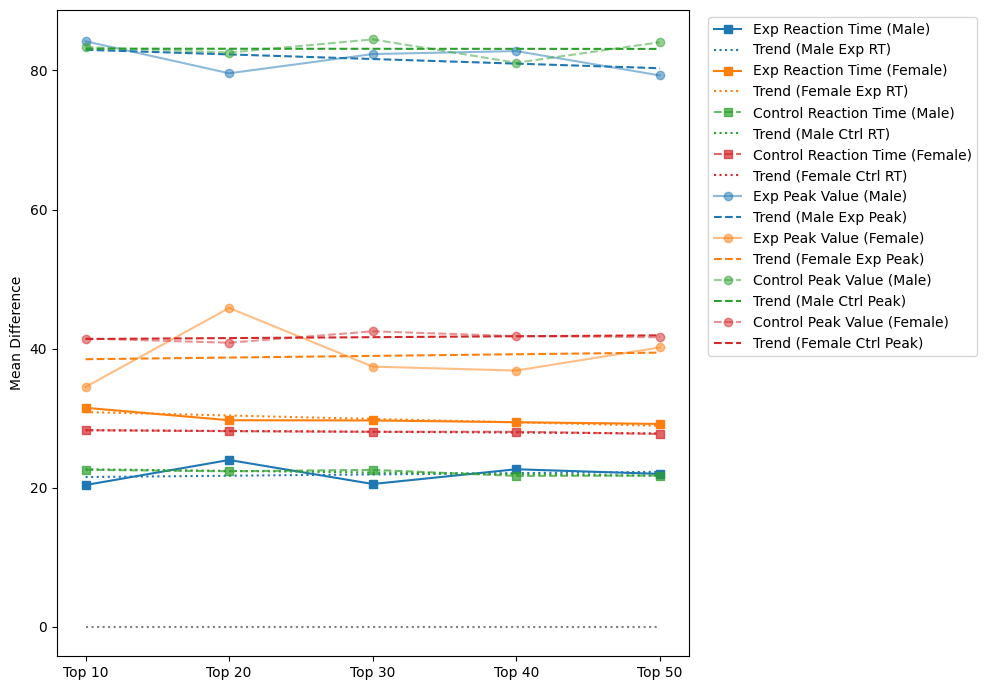

In [14]:
# ...existing code...

fig, ax = plt.subplots(figsize=(10, 7))

# --- Reaction Time ---
ax.plot(x, male_rt_means, marker='s', linestyle='-', label='Exp Reaction Time (Male)', color='tab:blue')
plot_trendline(ax, x, male_rt_means, color='tab:blue', linestyle=':', label='Trend (Male Exp RT)')
ax.plot(x, female_rt_means, marker='s', linestyle='-', label='Exp Reaction Time (Female)', color='tab:orange')
plot_trendline(ax, x, female_rt_means, color='tab:orange', linestyle=':', label='Trend (Female Exp RT)')
ax.plot(x, male_rt_control_means, marker='s', linestyle='--', label='Control Reaction Time (Male)', color='tab:green', alpha=0.7)
plot_trendline(ax, x, male_rt_control_means, color='tab:green', linestyle=':', label='Trend (Male Ctrl RT)')
ax.plot(x, female_rt_control_means, marker='s', linestyle='--', label='Control Reaction Time (Female)', color='tab:red', alpha=0.7)
plot_trendline(ax, x, female_rt_control_means, color='tab:red', linestyle=':', label='Trend (Female Ctrl RT)')

# --- Peak Value ---
ax.plot(x, male_peak_means, marker='o', linestyle='-', label='Exp Peak Value (Male)', color='tab:blue', alpha=0.5)
plot_trendline(ax, x, male_peak_means, color='tab:blue', linestyle='--', label='Trend (Male Exp Peak)')
ax.plot(x, female_peak_means, marker='o', linestyle='-', label='Exp Peak Value (Female)', color='tab:orange', alpha=0.5)
plot_trendline(ax, x, female_peak_means, color='tab:orange', linestyle='--', label='Trend (Female Exp Peak)')
ax.plot(x, male_peak_control_means, marker='o', linestyle='--', label='Control Peak Value (Male)', color='tab:green', alpha=0.5)
plot_trendline(ax, x, male_peak_control_means, color='tab:green', linestyle='--', label='Trend (Male Ctrl Peak)')
ax.plot(x, female_peak_control_means, marker='o', linestyle='--', label='Control Peak Value (Female)', color='tab:red', alpha=0.5)
plot_trendline(ax, x, female_peak_control_means, color='tab:red', linestyle='--', label='Trend (Female Ctrl Peak)')

ax.plot(x, [0]*len(x), linestyle=':', color='gray', alpha=1)
ax.set_xticks(x)
ax.set_xticklabels(xticks)
ax.set_ylabel('Mean Difference')
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)  # Legend outside plot
plt.tight_layout()
plt.show()

# ...existing code...